In [1]:
import json
import jsonlines
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
from sklearn.metrics import silhouette_score

from importlib import reload
import xenium_cluster
reload(xenium_cluster)
from xenium_cluster import XeniumCluster

from scipy.sparse import csr_matrix

# Variables Setup

In [2]:
dataset_name = "hBreast"
models = ["BayXenSmooth", "Leiden", "Louvain", "K-Means", "K-Means_No_Spatial", "Hierarchical", "Hierarchical_No_Spatial", "BayesSpace"]
resolutions = [0.75, 1.0]
spot_sizes = [100, 75, 50]
K_values = [17]

In [3]:
# BayXenSmooth Hyperparameters
BayXenSmooth_PCs = [5, 10, 15, 25]
KMeansInit = True
neighborhood_sizes = [1,2,3,4,5]
sample_for_assignment = False
concentration_amp = 1.0
spatial_norms = [0.05, 0.1, 0.25, 0.5, 1.0]
aggs = ["sum", "mean"]

# Load Data

In [4]:
# Path to your .gz file
file_path = f'data/{dataset_name}/transcripts.csv.gz'

# Read the gzipped CSV file into a DataFrame
df_transcripts = pd.read_csv(file_path, compression='gzip')

# drop cells without ids
df_transcripts = df_transcripts[df_transcripts["cell_id"] != -1]

# drop blanks and controls
df_transcripts = df_transcripts[~df_transcripts["feature_name"].str.startswith('BLANK_') & ~df_transcripts["feature_name"].str.startswith('NegControl')]

# Other Metric Implementations

- Variation Index (TODO) If we want to compare competing methods clustering with our clustering.


In [5]:
def morans_i_cluster_similarity(clustering, locations, clusters):
    print("Starting Moran's I Calculation.")
    moran_clusters = ad.AnnData(locations)
    sc.pp.neighbors(moran_clusters, n_pcs=0, n_neighbors=100)
    print("Neighbors calculated.")

    cluster_labels = clusters.values
    # Calculate Moran's I for the binary presence of each cluster
    unique_clusters = np.unique(cluster_labels)
    morans_i_results = {}
    for cluster in unique_clusters:
        cluster_indicator = (cluster_labels == cluster).astype(int)
        morans_i = sc.metrics.morans_i(moran_clusters, vals=cluster_indicator)
        morans_i_results[cluster] = morans_i

    print("Done!")
    return np.mean(list(morans_i_results.values()))

In [6]:
def gearys_c_cluster_similarity(clustering, locations, clusters):
    print("Starting Gearys's C Calculation.")
    gearys_clusters = ad.AnnData(locations)
    sc.pp.neighbors(gearys_clusters, n_pcs=0, n_neighbors=100)
    print("Neighbors calculated.")

    cluster_labels = clusters.values
    # Calculate Gearys C for the binary presence of each cluster
    unique_clusters = np.unique(cluster_labels)
    gearys_c_results = {}
    for cluster in unique_clusters:
        cluster_indicator = (cluster_labels == cluster).astype(int)
        gearys_c = sc.metrics.gearys_c(gearys_clusters, vals=cluster_indicator)
        gearys_c_results[cluster] = gearys_c

    print("Done!")
    return np.mean(list(gearys_c_results.values()))

In [7]:
def save_results(results, dataset_name, method, metric_name, spot_size, n_pcs=None, resolution=None, K=17, neighborhood_size=1, sample_for_assignment=True, concentration_amp=1.0):
    if resolution is not None:
        directory = f"results/{dataset_name}/{method}/{resolution}/{metric_name}/{spot_size}"
    elif method == "BayXenSmooth":
        directory = f"results/{dataset_name}/{method}/clusters/PCA/{n_pcs}/KMEANSINIT=True/NEIGHBORSIZE={neighborhood_size}/NUMCLUSTERS={K}/SPATIALINIT={True if spatial_norm > 0.0 else False}/SAMPLEFORASSIGNMENT={sample_for_assignment}/SPATIALNORM={spatial_norm}/SPATIALPRIORMULT={concentration_amp}/SPOTSIZE={spot_size}/AGG={agg}"
    else:
        directory = f"results/{dataset_name}/{method}/{K}/{metric_name}/{spot_size}"
    print(directory)
    if not os.path.exists(directory):
        os.makedirs(directory)
    with jsonlines.open(f"{directory}/{metric_name}.jsonl", mode='w') as writer:
        try:
            for key, value in results.items():
                writer.write({key: value})
        except AttributeError: # b/c it's not a dictionary so .items() fails
            writer.write(results)

# Calculate the Silhouette Score (and other metrics of note.)

In [ ]:
for spot_size in spot_sizes:
    clustering = XeniumCluster(data=df_transcripts, dataset_name=dataset_name)
    clustering.set_spot_size(spot_size)
    clustering.create_spot_data(third_dim=False, save_data=True)
    locations = clustering.xenium_spot_data.obs[["row", "col"]]
    for model in models:
        for K in K_values:
            if model in ["Leiden", "Louvain"]:
                for resolution in resolutions:
                    clusters = pd.read_csv(f"results/{dataset_name}/{model}/{resolution}/clusters/{spot_size}/clusters_RES={resolution}.csv")[f"{model} cluster"]
                    save_results(silhouette_score(locations, clusters), dataset_name, model, "silhouette_score", spot_size, resolution=resolution)
                    save_results(morans_i_cluster_similarity(clustering, locations, clusters), dataset_name, model, "morans_i", spot_size, resolution=resolution)
                    save_results(gearys_c_cluster_similarity(clustering, locations, clusters), dataset_name, model, "gearys_c", spot_size, resolution=resolution)
            elif model == "BayXenSmooth":
                min_expressions_per_spot = 10
                clustering.xenium_spot_data = clustering.xenium_spot_data[clustering.xenium_spot_data.X.sum(axis=1) > min_expressions_per_spot]
                for neighborhood_size in neighborhood_sizes:
                    clusters = pd.read_csv(f"results/{dataset_name}/{model}/clusters/PCA/{BayXenSmooth_PCs}/KMEANSINIT=True/NEIGHBORSIZE={neighborhood_size}/NUMCLUSTERS={K}/SPATIALINIT=True/SAMPLEFORASSIGNMENT={sample_for_assignment}/SPATIALNORM={spatial_norm}/SPATIALPRIORMULT={concentration_amp}/SPOTSIZE={spot_size}/AGG={agg}/clusters_K={K}.csv")[f"{model} cluster"]
                    save_results(silhouette_score(locations, clusters), dataset_name, model, "silhouette_score", spot_size, K=K)
                    save_results(morans_i_cluster_similarity(clustering, locations, clusters), dataset_name, model, "morans_i", spot_size, K=K, sample_for_assignment=sample_for_assignment)
                    save_results(gearys_c_cluster_similarity(clustering, locations, clusters), dataset_name, model, "gearys_c", spot_size, K=K, sample_for_assignment=sample_for_assignment)
            else:
                clusters = pd.read_csv(f"results/{dataset_name}/{model}/{K}/clusters/{spot_size}/clusters_K={K}.csv")[f"{model} cluster"]
                save_results(silhouette_score(locations, clusters), dataset_name, model, "silhouette_score", spot_size, K=K)
                save_results(morans_i_cluster_similarity(clustering, locations, clusters), dataset_name, model, "morans_i", spot_size, K=K)
                save_results(gearys_c_cluster_similarity(clustering, locations, clusters), dataset_name, model, "gearys_c", spot_size, K=K)

# Marker Gene Autocorrelation

In [8]:
MARKER_GENES = ["BANK1", "CEACAM6", "FASN", "FGL2", "IL7R", "KRT6B", "POSTN", "TCIM"]

In [9]:
def gene_morans_i(clustering, locations, clusters, num_neighbors=100, marker_genes=MARKER_GENES):
    print("Starting Moran's I Calculation.")
    moran_clusters = ad.AnnData(locations)
    sc.pp.neighbors(moran_clusters, n_pcs=0, n_neighbors=num_neighbors)
    print("Neighbors calculated.")

    # Create a binary adjacency matrix indicating if points are in the same cluster
    cluster_labels = clusters.values
    same_cluster = (cluster_labels[:, None] == cluster_labels).astype(int)
    print(moran_clusters.obsp["connectivities"].shape, same_cluster.shape)
    moran_clusters.obsp["connectivities"] = moran_clusters.obsp["connectivities"].multiply(csr_matrix(same_cluster))
    print("Connectivities formed.")

    # Calculate Moran's I for the genes
    morans_i = sc.metrics.morans_i(moran_clusters, vals=clustering.xenium_spot_data.X.T)

    morans_i_dict = dict(zip(clustering.xenium_spot_data.var.index, morans_i))

    for gene in marker_genes:
        print(num_neighbors, gene, morans_i_dict[gene])

    return morans_i_dict

In [10]:
def gene_gearys_c(clustering, locations, clusters, num_neighbors=100):
    print("Starting Geary's C Calculation.")
    gearys_clusters = ad.AnnData(locations)
    sc.pp.neighbors(gearys_clusters, n_pcs=0, n_neighbors=num_neighbors)
    print("Neighbors calculated.")

    # Create a binary adjacency matrix indicating if points are in the same cluster
    cluster_labels = clusters.values
    same_cluster = (cluster_labels[:, None] == cluster_labels).astype(int)
    gearys_clusters.obsp["connectivities"] = gearys_clusters.obsp["connectivities"].multiply(csr_matrix(same_cluster))
    print("Connectivities formed.")

    # Calculate Geary's C for the genes
    gearys_c= sc.metrics.gearys_c(gearys_clusters, vals=clustering.xenium_spot_data.X.T)

    gearys_c_dict = dict(zip(clustering.xenium_spot_data.var.index, gearys_c))

    return gearys_c_dict

In [11]:
models = ["BayXenSmooth"]
spot_sizes = [50]
spatial_norms = [0.0, 0.05, 0.1]
neighborhood_sizes = [1]
concentration_amps = [0.05, 0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 2.5]
num_neighboring_spots = [100]

In [13]:
for spot_size in spot_sizes:
    clustering = XeniumCluster(data=df_transcripts, dataset_name=dataset_name)
    clustering.set_spot_size(spot_size)
    clustering.create_spot_data(third_dim=False, save_data=True)
    locations = clustering.xenium_spot_data.obs[["row", "col"]]
    for model in models:
        print(model)
        for neighboring_spots in num_neighboring_spots:
            for K in K_values:
                if model in ["Leiden", "Louvain"]:
                    for resolution in resolutions:
                        clusters = pd.read_csv(f"results/{dataset_name}/{model}/{resolution}/clusters/{spot_size}/clusters_RES={resolution}.csv")[f"{model} cluster"]
                        save_results(gene_morans_i(clustering, locations, clusters, num_neighbors=neighboring_spots), dataset_name, model, "morans_i_by_gene", spot_size, resolution=resolution)
                        # save_results(gene_gearys_c(clustering, locations, clusters), dataset_name, model, "gearys_c_by_gene", spot_size, resolution=resolution)
                elif model == "BayXenSmooth":
                    for neighborhood_size in neighborhood_sizes:
                        for sample_for_assignment in [False, True]:
                            for agg in aggs:
                                for spatial_norm in spatial_norms:
                                    for n_pcs in BayXenSmooth_PCs:
                                        for concentration_amp in concentration_amps:
                                            try:
                                                clusters = pd.read_csv(f"results/{dataset_name}/{model}/clusters/PCA/{n_pcs}/KMEANSINIT=True/NEIGHBORSIZE={neighborhood_size}/NUMCLUSTERS={K}/SPATIALINIT={True if spatial_norm > 0.0 else False}/SAMPLEFORASSIGNMENT={sample_for_assignment}/SPATIALNORM={spatial_norm}/SPATIALPRIORMULT={concentration_amp}/SPOTSIZE={spot_size}/AGG={agg}/clusters_K={K}.csv")[f"{model} cluster"]
                                                save_results(gene_morans_i(clustering, locations, clusters, num_neighbors=neighboring_spots), dataset_name, model, "morans_i_by_gene", spot_size, K=K, neighborhood_size=neighborhood_size, sample_for_assignment=sample_for_assignment, concentration_amp=concentration_amp, n_pcs=n_pcs)
                                                # save_results(gene_gearys_c(clustering, locations, clusters), dataset_name, model, "gearys_c_by_gene", spot_size, K=K, neighborhood_size=neighborhood_size, sample_for_assignment=sample_for_assignment, concentration_amp=concentration_amp, n_pcs=n_pcs)
                                                print(f"BayXenSmooth with run {spot_size}um, {neighborhood_size} neighbors, sample={sample_for_assignment}, spatial_norm={spatial_norm}, concentraion_amp={concentration_amp}, n_pcs={n_pcs} and agg={agg} done!")
                                            except FileNotFoundError:
                                                continue
                else:
                    clusters = pd.read_csv(f"results/{dataset_name}/{model}/{K}/clusters/{spot_size}/clusters_K={K}.csv")[f"{model} cluster"]
                    save_results(gene_morans_i(clustering, locations, clusters, num_neighbors=neighboring_spots), dataset_name, model, "morans_i_by_gene", spot_size, K=K)
                    # save_results(gene_gearys_c(clustering, locations, clusters), dataset_name, model, "gearys_c_by_gene", spot_size, K=K)

/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


BayXenSmooth
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.907708372307093
100 CEACAM6 0.36694726585440274
100 FASN 1.0287252809835987
100 FGL2 0.4729363475587714
100 IL7R 0.7981575606475667
100 KRT6B 0.6059627150835672
100 POSTN 0.4718064927858906
100 TCIM 0.3961110999178802
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.0/SPATIALPRIORMULT=0.05/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.0, concentraion_amp=0.05, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.8664561884388431
100 CEACAM6 0.3671266131375941
100 FASN 1.0399797863580122
100 FGL2 0.46761238178875386
100 IL7R 0.770122446616413
100 KRT6B 0.5810328261130902
100 POSTN 0.49422181327000436
100 TCIM 0.3928073887159673
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.0/SPATIALPRIORMULT=0.1/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.0, concentraion_amp=0.1, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9013540400963999
100 CEACAM6 0.3722699814623138
100 FASN 1.0417717919501297
100 FGL2 0.4714815147306872
100 IL7R 0.7924309395325487
100 KRT6B 0.6091459465111415
100 POSTN 0.4636496699075181
100 TCIM 0.422113190040078
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.0/SPATIALPRIORMULT=0.25/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.0, concentraion_amp=0.25, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9132280311451105
100 CEACAM6 0.376453858629086
100 FASN 1.0602720093967484
100 FGL2 0.47151320060036733
100 IL7R 0.798136322667526
100 KRT6B 0.6138334956099044
100 POSTN 0.4565838458438176
100 TCIM 0.422760666221624
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.0/SPATIALPRIORMULT=0.5/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.0, concentraion_amp=0.5, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.8506480812467765
100 CEACAM6 0.3641460701776132
100 FASN 1.0216866604029813
100 FGL2 0.45856857777861193
100 IL7R 0.7496667771951949
100 KRT6B 0.5724020257067722
100 POSTN 0.4987581300042256
100 TCIM 0.38355100676751963
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.0/SPATIALPRIORMULT=0.75/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.0, concentraion_amp=0.75, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.872071584679825
100 CEACAM6 0.37307862205663916
100 FASN 1.0489175172396978
100 FGL2 0.4597437616399861
100 IL7R 0.7504776408762411
100 KRT6B 0.5956722969424479
100 POSTN 0.4829689666639248
100 TCIM 0.38143165375851246
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.0/SPATIALPRIORMULT=1.0/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.0, concentraion_amp=1.0, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.8918239569270486
100 CEACAM6 0.3665310143749828
100 FASN 1.0005548006597031
100 FGL2 0.47765482593059827
100 IL7R 0.7857962775661747
100 KRT6B 0.5808889879605673
100 POSTN 0.48073323865858497
100 TCIM 0.4045861163667592
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.0/SPATIALPRIORMULT=1.5/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.0, concentraion_amp=1.5, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.8866972929172813
100 CEACAM6 0.37024254178890426
100 FASN 1.0281770131861987
100 FGL2 0.4744950079970219
100 IL7R 0.7919171021359603
100 KRT6B 0.5905029794020245
100 POSTN 0.45890966113251447
100 TCIM 0.3826283688055651
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.0/SPATIALPRIORMULT=2.0/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.0, concentraion_amp=2.0, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9094800078149564
100 CEACAM6 0.3804987190131091
100 FASN 1.0677604865091697
100 FGL2 0.4571075096062451
100 IL7R 0.8016080135094679
100 KRT6B 0.616574634629247
100 POSTN 0.42165609065359194
100 TCIM 0.4560177136356973
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.0/SPATIALPRIORMULT=2.5/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.0, concentraion_amp=2.5, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.7920974502831047
100 CEACAM6 0.3560013487328159
100 FASN 0.9053338513795508
100 FGL2 0.42415304780320506
100 IL7R 0.7198413601016797
100 KRT6B 0.5291760984054154
100 POSTN 0.48646658732808695
100 TCIM 0.5322718288954031
results/hBreast/BayXenSmooth/clusters/PCA/25/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.0/SPATIALPRIORMULT=0.05/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.0, concentraion_amp=0.05, n_pcs=25 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.7797192820204939
100 CEACAM6 0.37416743554002413
100 FASN 0.9245108011747527
100 FGL2 0.40099166729456276
100 IL7R 0.6527978649540217
100 KRT6B 0.5012385185713061
100 POSTN 0.46330931313925955
100 TCIM 0.5364391601939815
results/hBreast/BayXenSmooth/clusters/PCA/25/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.0/SPATIALPRIORMULT=0.1/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.0, concentraion_amp=0.1, n_pcs=25 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.7765436403515826
100 CEACAM6 0.35460515986159996
100 FASN 0.8726872547514374
100 FGL2 0.42914285938897234
100 IL7R 0.7180305715917054
100 KRT6B 0.5200322349871456
100 POSTN 0.481199285165808
100 TCIM 0.5499687635032444
results/hBreast/BayXenSmooth/clusters/PCA/25/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.0/SPATIALPRIORMULT=0.25/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.0, concentraion_amp=0.25, n_pcs=25 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.8197635573345315
100 CEACAM6 0.37355393717169605
100 FASN 0.8817740172835913
100 FGL2 0.4137559995783901
100 IL7R 0.6716791588586208
100 KRT6B 0.5115116902928719
100 POSTN 0.48132938817418336
100 TCIM 0.5521830342264952
results/hBreast/BayXenSmooth/clusters/PCA/25/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.0/SPATIALPRIORMULT=0.5/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.0, concentraion_amp=0.5, n_pcs=25 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.775190437125118
100 CEACAM6 0.3690618439976505
100 FASN 0.8826226794197226
100 FGL2 0.42426140426802894
100 IL7R 0.7110919872089505
100 KRT6B 0.5145711978627016
100 POSTN 0.4794807521870446
100 TCIM 0.5045798613812973
results/hBreast/BayXenSmooth/clusters/PCA/25/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.0/SPATIALPRIORMULT=0.75/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.0, concentraion_amp=0.75, n_pcs=25 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.7779866812702539
100 CEACAM6 0.35678343721370814
100 FASN 0.8766095253485524
100 FGL2 0.43018794973947233
100 IL7R 0.7183201969931009
100 KRT6B 0.520982191013513
100 POSTN 0.4886875115160382
100 TCIM 0.5586639170558663
results/hBreast/BayXenSmooth/clusters/PCA/25/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.0/SPATIALPRIORMULT=1.0/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.0, concentraion_amp=1.0, n_pcs=25 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.6335145823203018
100 CEACAM6 0.35263652427479314
100 FASN 0.9079728959787154
100 FGL2 0.4325568780380431
100 IL7R 0.6772077124560275
100 KRT6B 0.5301277286800261
100 POSTN 0.5003258006352092
100 TCIM 0.5008741044163542
results/hBreast/BayXenSmooth/clusters/PCA/25/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.0/SPATIALPRIORMULT=1.5/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.0, concentraion_amp=1.5, n_pcs=25 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.7583889461826681
100 CEACAM6 0.36038460473972556
100 FASN 0.8617641459824639
100 FGL2 0.4415961609488341
100 IL7R 0.688861687986178
100 KRT6B 0.509790058164313
100 POSTN 0.48181437006220273
100 TCIM 0.544110330731954
results/hBreast/BayXenSmooth/clusters/PCA/25/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.0/SPATIALPRIORMULT=2.0/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.0, concentraion_amp=2.0, n_pcs=25 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.8728544803139869
100 CEACAM6 0.3615924817665722
100 FASN 1.0048323070239888
100 FGL2 0.4667564695003773
100 IL7R 0.7812216364028283
100 KRT6B 0.5759155808682525
100 POSTN 0.45240557598044717
100 TCIM 0.42015407906946456
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.05/SPATIALPRIORMULT=0.05/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.05, concentraion_amp=0.05, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9937487996458387
100 CEACAM6 0.38299940755283174
100 FASN 1.0219915291333737
100 FGL2 0.47372014015607655
100 IL7R 0.820960595341149
100 KRT6B 0.27180799846894027
100 POSTN 0.4946461107789426
100 TCIM 0.4134912749415494
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.05/SPATIALPRIORMULT=0.1/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.05, concentraion_amp=0.1, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.8878598919706894
100 CEACAM6 0.3732024485058791
100 FASN 1.0561568045095198
100 FGL2 0.46565089070382526
100 IL7R 0.764754496985258
100 KRT6B 0.5977933208868866
100 POSTN 0.4931446030328917
100 TCIM 0.407505075353471
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.05/SPATIALPRIORMULT=0.25/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.05, concentraion_amp=0.25, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9019161715486619
100 CEACAM6 0.36524768989393985
100 FASN 1.0284290307869455
100 FGL2 0.47222953511798155
100 IL7R 0.7842823632047512
100 KRT6B 0.6002752077344724
100 POSTN 0.47087672167684674
100 TCIM 0.36432494624417955
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.05/SPATIALPRIORMULT=0.5/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.05, concentraion_amp=0.5, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.8741165223282531
100 CEACAM6 0.37471263219643597
100 FASN 1.0257449898185889
100 FGL2 0.45684466195473955
100 IL7R 0.760076283422988
100 KRT6B 0.5940767872901185
100 POSTN 0.4616007316177204
100 TCIM 0.4073220320967417
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.05/SPATIALPRIORMULT=0.75/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.05, concentraion_amp=0.75, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9267625762309961
100 CEACAM6 0.38415663293622343
100 FASN 1.054097408027823
100 FGL2 0.46498633452943
100 IL7R 0.8007474069222418
100 KRT6B 0.5342020975059519
100 POSTN 0.43718702605917065
100 TCIM 0.4797117015227386
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.05/SPATIALPRIORMULT=1.0/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.05, concentraion_amp=1.0, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.891641366909332
100 CEACAM6 0.3653125501898346
100 FASN 1.0224371830351238
100 FGL2 0.46955392946794183
100 IL7R 0.7788015890863151
100 KRT6B 0.5973462867652335
100 POSTN 0.4578595221356049
100 TCIM 0.43916268154029614
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.05/SPATIALPRIORMULT=1.5/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.05, concentraion_amp=1.5, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.8839277670159824
100 CEACAM6 0.36675466906849635
100 FASN 1.0224293268283202
100 FGL2 0.4664399406098475
100 IL7R 0.7826285882358233
100 KRT6B 0.5864153930070098
100 POSTN 0.4740516656708101
100 TCIM 0.3929846037989414
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.05/SPATIALPRIORMULT=2.0/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.05, concentraion_amp=2.0, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9079853093503928
100 CEACAM6 0.37607409328059227
100 FASN 1.0404074469018323
100 FGL2 0.47565149996666384
100 IL7R 0.7960434037684918
100 KRT6B 0.6167832728809207
100 POSTN 0.4668602317155101
100 TCIM 0.4322008809320095
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.05/SPATIALPRIORMULT=2.5/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.05, concentraion_amp=2.5, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.859809841273559
100 CEACAM6 0.3465970080318811
100 FASN 0.8546759256318563
100 FGL2 0.4289292325750789
100 IL7R 0.7501066825043926
100 KRT6B 0.5025557164208183
100 POSTN 0.4963244844145567
100 TCIM 0.6091780861535828
results/hBreast/BayXenSmooth/clusters/PCA/25/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.05/SPATIALPRIORMULT=1.0/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.05, concentraion_amp=1.0, n_pcs=25 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9239544754759202
100 CEACAM6 0.37255585007329717
100 FASN 1.0429478397424332
100 FGL2 0.4763779744465754
100 IL7R 0.8082558071381334
100 KRT6B 0.6207148578952593
100 POSTN 0.4706923687275549
100 TCIM 0.4422114895816697
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.1/SPATIALPRIORMULT=0.05/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.1, concentraion_amp=0.05, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.8796324689543642
100 CEACAM6 0.3629167618217145
100 FASN 1.022910688413301
100 FGL2 0.4709417231791623
100 IL7R 0.7813598426038066
100 KRT6B 0.5846516007715445
100 POSTN 0.4693181221105796
100 TCIM 0.3946467243723949
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.1/SPATIALPRIORMULT=0.1/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.1, concentraion_amp=0.1, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.8992659784408242
100 CEACAM6 0.37516992800110355
100 FASN 1.0689063093566435
100 FGL2 0.4520029784035376
100 IL7R 0.7714965753313594
100 KRT6B 0.6062333845692744
100 POSTN 0.4370113110467006
100 TCIM 0.4435373180171278
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.1/SPATIALPRIORMULT=0.25/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.1, concentraion_amp=0.25, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.8988500994156746
100 CEACAM6 0.37244498945308385
100 FASN 1.0375959546827385
100 FGL2 0.46873975642685595
100 IL7R 0.7730812069747474
100 KRT6B 0.6097838761988669
100 POSTN 0.46159210022226976
100 TCIM 0.42425013414451446
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.1/SPATIALPRIORMULT=0.5/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.1, concentraion_amp=0.5, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9031356735101272
100 CEACAM6 0.36920593318382233
100 FASN 1.0365097766199194
100 FGL2 0.47205120929226413
100 IL7R 0.7944510500449341
100 KRT6B 0.6096092465168684
100 POSTN 0.4720294079867794
100 TCIM 0.4459978703435148
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.1/SPATIALPRIORMULT=0.75/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.1, concentraion_amp=0.75, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.8792652028868059
100 CEACAM6 0.38126873002258943
100 FASN 1.0546476401456804
100 FGL2 0.4550400322368364
100 IL7R 0.7665244940198717
100 KRT6B 0.5980580672474275
100 POSTN 0.4257184796236536
100 TCIM 0.41437695551864046
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.1/SPATIALPRIORMULT=1.0/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.1, concentraion_amp=1.0, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9098191030026338
100 CEACAM6 0.3724527742966326
100 FASN 1.022617686841909
100 FGL2 0.47577534804396404
100 IL7R 0.7987808399265461
100 KRT6B 0.6008800824423575
100 POSTN 0.47932882608575206
100 TCIM 0.4018106969458888
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.1/SPATIALPRIORMULT=1.5/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.1, concentraion_amp=1.5, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.8892319537596648
100 CEACAM6 0.3659285684703437
100 FASN 1.0196872809508282
100 FGL2 0.4646256829868969
100 IL7R 0.7838423306013782
100 KRT6B 0.5857430489111849
100 POSTN 0.47049944683502454
100 TCIM 0.3885285884224637
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.1/SPATIALPRIORMULT=2.0/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.1, concentraion_amp=2.0, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9048589471352902
100 CEACAM6 0.37311791992283233
100 FASN 1.0449890714098173
100 FGL2 0.4764990598933225
100 IL7R 0.7934595732398285
100 KRT6B 0.6125777332212401
100 POSTN 0.468275773407627
100 TCIM 0.4014483787492846
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.1/SPATIALPRIORMULT=2.5/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.1, concentraion_amp=2.5, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.900485485007846
100 CEACAM6 0.37339454748086925
100 FASN 0.8977464183575522
100 FGL2 0.4173695060276453
100 IL7R 0.7008807633691279
100 KRT6B 0.3816176454602541
100 POSTN 0.5127450015532266
100 TCIM 0.5466788684260608
results/hBreast/BayXenSmooth/clusters/PCA/25/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.1/SPATIALPRIORMULT=1.0/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.1, concentraion_amp=1.0, n_pcs=25 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9535509292978811
100 CEACAM6 0.37881820968139857
100 FASN 1.0793431974735999
100 FGL2 0.47399314623225913
100 IL7R 0.8157904254963043
100 KRT6B 0.6300331648273066
100 POSTN 0.4379355644321081
100 TCIM 0.4225608540779228
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.0/SPATIALPRIORMULT=0.05/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.0, concentraion_amp=0.05, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9488731696528286
100 CEACAM6 0.3739600993132112
100 FASN 1.046597354751622
100 FGL2 0.48087324206120585
100 IL7R 0.8290110109484442
100 KRT6B 0.6194079425194254
100 POSTN 0.4658949717754356
100 TCIM 0.4336555906373068
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.0/SPATIALPRIORMULT=0.1/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.0, concentraion_amp=0.1, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9047911233750187
100 CEACAM6 0.36878553978731415
100 FASN 0.9965911680750233
100 FGL2 0.4745074514012086
100 IL7R 0.7962611803201786
100 KRT6B 0.6017445053951341
100 POSTN 0.47753567904716354
100 TCIM 0.36200920171140105
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.0/SPATIALPRIORMULT=0.25/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.0, concentraion_amp=0.25, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9409003007573024
100 CEACAM6 0.36464138413031055
100 FASN 1.0010717276189562
100 FGL2 0.4890261205088297
100 IL7R 0.8216948215422286
100 KRT6B 0.6173829148720186
100 POSTN 0.49052271633202654
100 TCIM 0.4189863563179208
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.0/SPATIALPRIORMULT=0.5/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.0, concentraion_amp=0.5, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9472614721015612
100 CEACAM6 0.380086920188598
100 FASN 1.0280229698159167
100 FGL2 0.48019480753140437
100 IL7R 0.8033605006905933
100 KRT6B 0.6333909855534106
100 POSTN 0.5007561012166922
100 TCIM 0.369656604271696
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.0/SPATIALPRIORMULT=0.75/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.0, concentraion_amp=0.75, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9174933969589092
100 CEACAM6 0.3759486592909148
100 FASN 1.041810519940393
100 FGL2 0.4804126100868558
100 IL7R 0.801964525379481
100 KRT6B 0.6225153631159464
100 POSTN 0.47386867139720196
100 TCIM 0.40515504047720385
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.0/SPATIALPRIORMULT=1.0/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.0, concentraion_amp=1.0, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.8810202168049669
100 CEACAM6 0.3523733777739028
100 FASN 0.988014823128954
100 FGL2 0.45901627724577626
100 IL7R 0.7624062528583578
100 KRT6B 0.5756021149585208
100 POSTN 0.45891839974052606
100 TCIM 0.3765193427286621
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.0/SPATIALPRIORMULT=1.5/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.0, concentraion_amp=1.5, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9003622221600995
100 CEACAM6 0.36358920458583255
100 FASN 1.0262165002676031
100 FGL2 0.46476771708344083
100 IL7R 0.7802686958055528
100 KRT6B 0.6054068622263279
100 POSTN 0.47196677135513976
100 TCIM 0.38582105404420397
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.0/SPATIALPRIORMULT=2.0/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.0, concentraion_amp=2.0, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9187518220341045
100 CEACAM6 0.3707545221482387
100 FASN 1.032219389755112
100 FGL2 0.48720057574912495
100 IL7R 0.8239712607109981
100 KRT6B 0.6081969036592179
100 POSTN 0.46301922737524304
100 TCIM 0.3781295843118661
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.0/SPATIALPRIORMULT=2.5/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.0, concentraion_amp=2.5, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.8289557660887161
100 CEACAM6 0.37143016006593715
100 FASN 0.8883821662600037
100 FGL2 0.4113278225836329
100 IL7R 0.6794204204889642
100 KRT6B 0.5305470614224771
100 POSTN 0.4834271839165564
100 TCIM 0.5465155443149698
results/hBreast/BayXenSmooth/clusters/PCA/25/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.0/SPATIALPRIORMULT=0.05/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.0, concentraion_amp=0.05, n_pcs=25 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.805483293461689
100 CEACAM6 0.3701087743413276
100 FASN 0.926321576112563
100 FGL2 0.41169973593477766
100 IL7R 0.6884656351745166
100 KRT6B 0.5204119778583572
100 POSTN 0.4709733023666579
100 TCIM 0.565418743486944
results/hBreast/BayXenSmooth/clusters/PCA/25/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.0/SPATIALPRIORMULT=0.1/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.0, concentraion_amp=0.1, n_pcs=25 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.3104560296206515
100 CEACAM6 0.36420001508750205
100 FASN 0.8768332352373349
100 FGL2 0.4030689996951578
100 IL7R 0.5451796463651502
100 KRT6B 0.5228513416618511
100 POSTN 0.4956457495436743
100 TCIM 0.5719834841867438
results/hBreast/BayXenSmooth/clusters/PCA/25/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.0/SPATIALPRIORMULT=0.25/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.0, concentraion_amp=0.25, n_pcs=25 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.49868421297181514
100 CEACAM6 0.36904763680756747
100 FASN 0.9239649341579945
100 FGL2 0.4094994962716496
100 IL7R 0.6019775012537911
100 KRT6B 0.5159185313937713
100 POSTN 0.47660843614995546
100 TCIM 0.5217101946101541
results/hBreast/BayXenSmooth/clusters/PCA/25/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.0/SPATIALPRIORMULT=0.5/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.0, concentraion_amp=0.5, n_pcs=25 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.812364831194228
100 CEACAM6 0.37780610426912636
100 FASN 0.8871041209904655
100 FGL2 0.4028887458784557
100 IL7R 0.6752522164956931
100 KRT6B 0.5231070183148694
100 POSTN 0.4870880219773372
100 TCIM 0.5401687737710941
results/hBreast/BayXenSmooth/clusters/PCA/25/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.0/SPATIALPRIORMULT=0.75/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.0, concentraion_amp=0.75, n_pcs=25 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.831879275989532
100 CEACAM6 0.36131133593537845
100 FASN 0.8866207386343138
100 FGL2 0.4137727933566885
100 IL7R 0.6858007144684186
100 KRT6B 0.5369417195189812
100 POSTN 0.49130029257183855
100 TCIM 0.5345163547419911
results/hBreast/BayXenSmooth/clusters/PCA/25/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.0/SPATIALPRIORMULT=1.0/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.0, concentraion_amp=1.0, n_pcs=25 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.8678312561239881
100 CEACAM6 0.3534356106177417
100 FASN 0.9194672180304548
100 FGL2 0.4299975449096111
100 IL7R 0.7241978122185477
100 KRT6B 0.5569393701776025
100 POSTN 0.49410999787604476
100 TCIM 0.5457773146098952
results/hBreast/BayXenSmooth/clusters/PCA/25/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.0/SPATIALPRIORMULT=1.5/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.0, concentraion_amp=1.5, n_pcs=25 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.6367534784342543
100 CEACAM6 0.36249456828919197
100 FASN 0.8787546307661538
100 FGL2 0.4159144493032624
100 IL7R 0.5557311664755478
100 KRT6B 0.5485174146783006
100 POSTN 0.4953545342650125
100 TCIM 0.5901470674085375
results/hBreast/BayXenSmooth/clusters/PCA/25/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.0/SPATIALPRIORMULT=2.0/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.0, concentraion_amp=2.0, n_pcs=25 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.925134945819486
100 CEACAM6 0.37344154717229755
100 FASN 1.0544336561242846
100 FGL2 0.4844280013144262
100 IL7R 0.8217719863347122
100 KRT6B 0.6175477135404518
100 POSTN 0.49895307487599233
100 TCIM 0.4125206311068939
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.05/SPATIALPRIORMULT=0.05/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.05, concentraion_amp=0.05, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9200924228609414
100 CEACAM6 0.3583900168270914
100 FASN 1.0307692061389901
100 FGL2 0.47575226746929283
100 IL7R 0.8043163017351189
100 KRT6B 0.613588955754378
100 POSTN 0.4650460755633757
100 TCIM 0.42345519324478154
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.05/SPATIALPRIORMULT=0.1/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.05, concentraion_amp=0.1, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.8883095245300012
100 CEACAM6 0.3697707741798413
100 FASN 1.0487199975989263
100 FGL2 0.45781335187944067
100 IL7R 0.7540852554456353
100 KRT6B 0.594017992497562
100 POSTN 0.48820491451070697
100 TCIM 0.3712011909904877
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.05/SPATIALPRIORMULT=0.25/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.05, concentraion_amp=0.25, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.877519707324274
100 CEACAM6 0.37272064401740185
100 FASN 1.0432036237979536
100 FGL2 0.4683222266504408
100 IL7R 0.7850327960170067
100 KRT6B 0.6117688776850089
100 POSTN 0.44707316324628765
100 TCIM 0.37554634293350164
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.05/SPATIALPRIORMULT=0.5/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.05, concentraion_amp=0.5, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.8978482864217163
100 CEACAM6 0.37670339226480853
100 FASN 1.0604477681756834
100 FGL2 0.4507019792666695
100 IL7R 0.7861159534031965
100 KRT6B 0.6053477146072215
100 POSTN 0.42716753374592326
100 TCIM 0.42713788694990495
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.05/SPATIALPRIORMULT=0.75/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.05, concentraion_amp=0.75, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9376566710579551
100 CEACAM6 0.37177158014303874
100 FASN 1.0436248747375914
100 FGL2 0.472360519666272
100 IL7R 0.8028153952960898
100 KRT6B 0.6258968067332373
100 POSTN 0.46350402797439705
100 TCIM 0.41296980001326
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.05/SPATIALPRIORMULT=1.0/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.05, concentraion_amp=1.0, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9394957028014953
100 CEACAM6 0.37558046973003323
100 FASN 1.0478300948597574
100 FGL2 0.4885285224454608
100 IL7R 0.8324258931082661
100 KRT6B 0.6210385958093406
100 POSTN 0.4692100813181669
100 TCIM 0.43160726575877517
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.05/SPATIALPRIORMULT=1.5/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.05, concentraion_amp=1.5, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9373017084378654
100 CEACAM6 0.3683328908133171
100 FASN 0.9795792925660308
100 FGL2 0.49651274840145426
100 IL7R 0.8182036633600994
100 KRT6B 0.6199549221164807
100 POSTN 0.4944328606702882
100 TCIM 0.42422375928234174
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.05/SPATIALPRIORMULT=2.0/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.05, concentraion_amp=2.0, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9073805647342088
100 CEACAM6 0.3657533224146092
100 FASN 1.0255571249694424
100 FGL2 0.47761274237322676
100 IL7R 0.8085228863052478
100 KRT6B 0.6061822840204879
100 POSTN 0.4694913836204643
100 TCIM 0.36580605008686906
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.05/SPATIALPRIORMULT=2.5/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.05, concentraion_amp=2.5, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.8567459624631877
100 CEACAM6 0.35451859017637966
100 FASN 0.8701940859130032
100 FGL2 0.43676492243989967
100 IL7R 0.7306960790342507
100 KRT6B 0.550750898752746
100 POSTN 0.48786084062181445
100 TCIM 0.569932742957946
results/hBreast/BayXenSmooth/clusters/PCA/25/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.05/SPATIALPRIORMULT=1.0/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.05, concentraion_amp=1.0, n_pcs=25 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.906330606315822
100 CEACAM6 0.3815493785630264
100 FASN 1.0760352730359952
100 FGL2 0.4715242468700831
100 IL7R 0.7955663557790172
100 KRT6B 0.6263382906321946
100 POSTN 0.4471588077216542
100 TCIM 0.4240820605009441
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.1/SPATIALPRIORMULT=0.05/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.1, concentraion_amp=0.05, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.8722104346020996
100 CEACAM6 0.36880992641661275
100 FASN 1.013054423316553
100 FGL2 0.47359385746170557
100 IL7R 0.7878266767227037
100 KRT6B 0.5832987671343544
100 POSTN 0.46581181752871503
100 TCIM 0.38388879319451114
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.1/SPATIALPRIORMULT=0.1/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.1, concentraion_amp=0.1, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.8759322997154705
100 CEACAM6 0.3664281238920648
100 FASN 1.0142281441566168
100 FGL2 0.4716698908809114
100 IL7R 0.787245719512906
100 KRT6B 0.5878696757886436
100 POSTN 0.4629472492131902
100 TCIM 0.4110295355450153
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.1/SPATIALPRIORMULT=0.25/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.1, concentraion_amp=0.25, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.8856107862106186
100 CEACAM6 0.3683429556555498
100 FASN 1.0087405262910494
100 FGL2 0.46911551196234275
100 IL7R 0.7867310468390184
100 KRT6B 0.5852794688195688
100 POSTN 0.45940807075453943
100 TCIM 0.4164660814562733
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.1/SPATIALPRIORMULT=0.5/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.1, concentraion_amp=0.5, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.906588540339189
100 CEACAM6 0.367183332468411
100 FASN 1.02386031872385
100 FGL2 0.46714114358397807
100 IL7R 0.7933048627924101
100 KRT6B 0.6073528574442391
100 POSTN 0.46840105369671514
100 TCIM 0.39317348321684553
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.1/SPATIALPRIORMULT=0.75/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.1, concentraion_amp=0.75, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9118339982754557
100 CEACAM6 0.3737053198617258
100 FASN 1.0328446238465643
100 FGL2 0.47430310086262095
100 IL7R 0.800281574188733
100 KRT6B 0.6096339661908919
100 POSTN 0.4576911765771416
100 TCIM 0.4162196941904975
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.1/SPATIALPRIORMULT=1.0/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.1, concentraion_amp=1.0, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9091700580487194
100 CEACAM6 0.37551484269076446
100 FASN 1.0515568897129606
100 FGL2 0.4625753107117002
100 IL7R 0.7920823848026103
100 KRT6B 0.6010403921830213
100 POSTN 0.45711564026442747
100 TCIM 0.40558211421025936
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.1/SPATIALPRIORMULT=1.5/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.1, concentraion_amp=1.5, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9192080450754201
100 CEACAM6 0.37229639754190896
100 FASN 1.0293706936274416
100 FGL2 0.4703167326563554
100 IL7R 0.8101280864909721
100 KRT6B 0.6029850499373693
100 POSTN 0.46898553493581374
100 TCIM 0.3889830528078014
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.1/SPATIALPRIORMULT=2.0/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.1, concentraion_amp=2.0, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9468793282177659
100 CEACAM6 0.37391283510909623
100 FASN 1.0434842662661927
100 FGL2 0.481098314629049
100 IL7R 0.8188698118195004
100 KRT6B 0.6269212041490891
100 POSTN 0.4682648604088353
100 TCIM 0.448570614170274
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.1/SPATIALPRIORMULT=2.5/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.1, concentraion_amp=2.5, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.8504945079823981
100 CEACAM6 0.3645903833827773
100 FASN 0.8893772352359702
100 FGL2 0.42206389099913055
100 IL7R 0.6880115921224726
100 KRT6B 0.558185773440137
100 POSTN 0.4920361245132767
100 TCIM 0.5524948261375049
results/hBreast/BayXenSmooth/clusters/PCA/25/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.1/SPATIALPRIORMULT=1.0/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=False, spatial_norm=0.1, concentraion_amp=1.0, n_pcs=25 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9326641451907859
100 CEACAM6 0.3644706200189561
100 FASN 1.0302592103653974
100 FGL2 0.47695968877468026
100 IL7R 0.8087463504596056
100 KRT6B 0.6105215221547051
100 POSTN 0.46758579617093937
100 TCIM 0.4201107767792882
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.0/SPATIALPRIORMULT=0.05/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.0, concentraion_amp=0.05, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.8839196117405004
100 CEACAM6 0.3672312224796923
100 FASN 1.0428742917942122
100 FGL2 0.468049789156414
100 IL7R 0.7847023791334509
100 KRT6B 0.5922821121975183
100 POSTN 0.4929966805483095
100 TCIM 0.4144814333064185
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.0/SPATIALPRIORMULT=0.1/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.0, concentraion_amp=0.1, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9097769588129921
100 CEACAM6 0.3817652090299655
100 FASN 1.0461266193663792
100 FGL2 0.47570182798814525
100 IL7R 0.8175774591333577
100 KRT6B 0.6207256607556355
100 POSTN 0.4678180755985276
100 TCIM 0.4197947336245973
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.0/SPATIALPRIORMULT=0.25/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.0, concentraion_amp=0.25, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9188856173033695
100 CEACAM6 0.3770547225047324
100 FASN 1.0617271232232977
100 FGL2 0.47771967357229483
100 IL7R 0.8140432245539125
100 KRT6B 0.6224658565824069
100 POSTN 0.46191888277418075
100 TCIM 0.42780286033154946
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.0/SPATIALPRIORMULT=0.5/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.0, concentraion_amp=0.5, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.832083063551975
100 CEACAM6 0.3657997264288849
100 FASN 1.0264456362453867
100 FGL2 0.46289918153439885
100 IL7R 0.7715980839560147
100 KRT6B 0.5867381842983682
100 POSTN 0.4991956254141276
100 TCIM 0.40415794589076004
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.0/SPATIALPRIORMULT=0.75/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.0, concentraion_amp=0.75, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.8896616407312318
100 CEACAM6 0.3760804899320596
100 FASN 1.0428365530456785
100 FGL2 0.458240547330253
100 IL7R 0.7514323102115523
100 KRT6B 0.6058287202265865
100 POSTN 0.48288336427854806
100 TCIM 0.38551295496255117
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.0/SPATIALPRIORMULT=1.0/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.0, concentraion_amp=1.0, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.8989334564133816
100 CEACAM6 0.3646146606515226
100 FASN 1.0025552892669856
100 FGL2 0.4770758716959326
100 IL7R 0.7877760548209635
100 KRT6B 0.5866033749113128
100 POSTN 0.4838027869910887
100 TCIM 0.3883788993970795
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.0/SPATIALPRIORMULT=1.5/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.0, concentraion_amp=1.5, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9025613933054749
100 CEACAM6 0.371283848247465
100 FASN 1.0283029125923786
100 FGL2 0.4741845053472776
100 IL7R 0.7952906600210861
100 KRT6B 0.5961226936257924
100 POSTN 0.45808207361566766
100 TCIM 0.40336598583424094
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.0/SPATIALPRIORMULT=2.0/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.0, concentraion_amp=2.0, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9222907216205422
100 CEACAM6 0.37843619390783156
100 FASN 1.0693822435637101
100 FGL2 0.4634666315709451
100 IL7R 0.7927423950863158
100 KRT6B 0.6218616970120044
100 POSTN 0.4292217282486683
100 TCIM 0.44711928910475557
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.0/SPATIALPRIORMULT=2.5/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.0, concentraion_amp=2.5, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.821409959524065
100 CEACAM6 0.35479303332768075
100 FASN 0.9046890725134618
100 FGL2 0.4340626610726024
100 IL7R 0.7528693500418884
100 KRT6B 0.5453293658216352
100 POSTN 0.4913436168679847
100 TCIM 0.5508067750253852
results/hBreast/BayXenSmooth/clusters/PCA/25/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.0/SPATIALPRIORMULT=0.05/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.0, concentraion_amp=0.05, n_pcs=25 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.77372233842672
100 CEACAM6 0.36900922788945106
100 FASN 0.9271773307460459
100 FGL2 0.40675120963256356
100 IL7R 0.666719944444423
100 KRT6B 0.5120347553633076
100 POSTN 0.46776100847388247
100 TCIM 0.5530508748966502
results/hBreast/BayXenSmooth/clusters/PCA/25/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.0/SPATIALPRIORMULT=0.1/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.0, concentraion_amp=0.1, n_pcs=25 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.804554311526364
100 CEACAM6 0.354767153473843
100 FASN 0.8780433160759065
100 FGL2 0.4357814914560306
100 IL7R 0.7395131364555543
100 KRT6B 0.5373150090865411
100 POSTN 0.48835992093207653
100 TCIM 0.5742035064750731
results/hBreast/BayXenSmooth/clusters/PCA/25/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.0/SPATIALPRIORMULT=0.25/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.0, concentraion_amp=0.25, n_pcs=25 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.834933205340929
100 CEACAM6 0.3711516122071354
100 FASN 0.8875381387732338
100 FGL2 0.42438178972388496
100 IL7R 0.6887447236457853
100 KRT6B 0.5262263303461019
100 POSTN 0.48257056314529195
100 TCIM 0.554938138382831
results/hBreast/BayXenSmooth/clusters/PCA/25/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.0/SPATIALPRIORMULT=0.5/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.0, concentraion_amp=0.5, n_pcs=25 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.7895561243379112
100 CEACAM6 0.36824015942227717
100 FASN 0.885874269552728
100 FGL2 0.4272382995511911
100 IL7R 0.717501876239274
100 KRT6B 0.5293373435100586
100 POSTN 0.48236166962081856
100 TCIM 0.5140241431634947
results/hBreast/BayXenSmooth/clusters/PCA/25/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.0/SPATIALPRIORMULT=0.75/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.0, concentraion_amp=0.75, n_pcs=25 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.795896485160909
100 CEACAM6 0.3526524361617663
100 FASN 0.8796702119182745
100 FGL2 0.43616331264447356
100 IL7R 0.7343631307886324
100 KRT6B 0.5321022168655875
100 POSTN 0.48978311452178863
100 TCIM 0.5682246810795527
results/hBreast/BayXenSmooth/clusters/PCA/25/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.0/SPATIALPRIORMULT=1.0/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.0, concentraion_amp=1.0, n_pcs=25 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.6397411434737446
100 CEACAM6 0.3535900859809498
100 FASN 0.9107973596924052
100 FGL2 0.4396192532742811
100 IL7R 0.6821521050671853
100 KRT6B 0.5405062528870129
100 POSTN 0.5079952839851442
100 TCIM 0.5041440426107084
results/hBreast/BayXenSmooth/clusters/PCA/25/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.0/SPATIALPRIORMULT=1.5/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.0, concentraion_amp=1.5, n_pcs=25 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.759843592611048
100 CEACAM6 0.35911793905909045
100 FASN 0.8588703458233836
100 FGL2 0.4468436217867867
100 IL7R 0.69216630622257
100 KRT6B 0.5095450474328244
100 POSTN 0.4755940081749109
100 TCIM 0.5459204216406204
results/hBreast/BayXenSmooth/clusters/PCA/25/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.0/SPATIALPRIORMULT=2.0/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.0, concentraion_amp=2.0, n_pcs=25 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.8811557752210353
100 CEACAM6 0.36800398920201777
100 FASN 1.0072656941871805
100 FGL2 0.47035762131151837
100 IL7R 0.7902747414888281
100 KRT6B 0.5760158581317794
100 POSTN 0.4543840602612161
100 TCIM 0.4020469967113906
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.05/SPATIALPRIORMULT=0.05/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.05, concentraion_amp=0.05, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 1.038865958412267
100 CEACAM6 0.3838659055787026
100 FASN 1.026130555090333
100 FGL2 0.4830573512027845
100 IL7R 0.8415518511662001
100 KRT6B 0.2827189479361522
100 POSTN 0.49548399282942707
100 TCIM 0.3690085254926071
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.05/SPATIALPRIORMULT=0.1/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.05, concentraion_amp=0.1, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.8960539985205555
100 CEACAM6 0.3782434857600031
100 FASN 1.0594459735735644
100 FGL2 0.4674670398128157
100 IL7R 0.7615680479408825
100 KRT6B 0.6069304778462286
100 POSTN 0.4945525347368348
100 TCIM 0.41733018566659885
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.05/SPATIALPRIORMULT=0.25/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.05, concentraion_amp=0.25, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9174100824865451
100 CEACAM6 0.3661362947109239
100 FASN 1.0381019342112758
100 FGL2 0.47032871743749566
100 IL7R 0.7815627721046144
100 KRT6B 0.6210348758656506
100 POSTN 0.47505022672193115
100 TCIM 0.37531522644216164
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.05/SPATIALPRIORMULT=0.5/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.05, concentraion_amp=0.5, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.8959551568699279
100 CEACAM6 0.3754510785078306
100 FASN 1.0362777994005665
100 FGL2 0.46731212761142743
100 IL7R 0.7673696061540621
100 KRT6B 0.6102755913312489
100 POSTN 0.46940825821010324
100 TCIM 0.40126637306620244
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.05/SPATIALPRIORMULT=0.75/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.05, concentraion_amp=0.75, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9572905560929167
100 CEACAM6 0.38217961651717414
100 FASN 1.0607802530628754
100 FGL2 0.4684141054899748
100 IL7R 0.8123373077744099
100 KRT6B 0.5418248077472642
100 POSTN 0.4415971017780407
100 TCIM 0.4443666815464866
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.05/SPATIALPRIORMULT=1.0/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.05, concentraion_amp=1.0, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.8962132046478115
100 CEACAM6 0.36837810878596916
100 FASN 1.024670934321699
100 FGL2 0.4740521820826144
100 IL7R 0.7742793157524213
100 KRT6B 0.5899884085113088
100 POSTN 0.45973490240705306
100 TCIM 0.41985454770215275
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.05/SPATIALPRIORMULT=1.5/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.05, concentraion_amp=1.5, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.8429608834998169
100 CEACAM6 0.3663133465939899
100 FASN 1.0219816068781293
100 FGL2 0.46577708901787446
100 IL7R 0.7808713477702073
100 KRT6B 0.587546522712525
100 POSTN 0.46793606686865796
100 TCIM 0.3978192794571135
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.05/SPATIALPRIORMULT=2.0/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.05, concentraion_amp=2.0, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.8682806051400842
100 CEACAM6 0.3711417464950431
100 FASN 1.0436536789944908
100 FGL2 0.4803409005399183
100 IL7R 0.8026540455173864
100 KRT6B 0.6200428004393345
100 POSTN 0.46285841177803805
100 TCIM 0.41268574649692485
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.05/SPATIALPRIORMULT=2.5/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.05, concentraion_amp=2.5, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.8731967670554959
100 CEACAM6 0.3485770109667555
100 FASN 0.8601626490802889
100 FGL2 0.4373895855994238
100 IL7R 0.7587160751633196
100 KRT6B 0.5085190437285048
100 POSTN 0.49715526552662365
100 TCIM 0.6009481801996602
results/hBreast/BayXenSmooth/clusters/PCA/25/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.05/SPATIALPRIORMULT=1.0/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.05, concentraion_amp=1.0, n_pcs=25 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9531406061449152
100 CEACAM6 0.37459838880138824
100 FASN 1.0500489802122914
100 FGL2 0.47700642393181203
100 IL7R 0.8254607939031932
100 KRT6B 0.6229350142637559
100 POSTN 0.4635203226831034
100 TCIM 0.42342799336777137
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.1/SPATIALPRIORMULT=0.05/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.1, concentraion_amp=0.05, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9072500728731554
100 CEACAM6 0.3717530060227462
100 FASN 1.031480437343003
100 FGL2 0.47783966186775545
100 IL7R 0.7885647883763515
100 KRT6B 0.597339074578515
100 POSTN 0.46644068886349177
100 TCIM 0.40487597675087
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.1/SPATIALPRIORMULT=0.1/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.1, concentraion_amp=0.1, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.8728879377122845
100 CEACAM6 0.37512187996270663
100 FASN 1.0712787276135327
100 FGL2 0.4580340528091506
100 IL7R 0.7657182155103083
100 KRT6B 0.6181940595734897
100 POSTN 0.44353752566784943
100 TCIM 0.4384664119924821
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.1/SPATIALPRIORMULT=0.25/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.1, concentraion_amp=0.25, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.8682944940597473
100 CEACAM6 0.37438572249171526
100 FASN 1.0405504627943347
100 FGL2 0.46190252312863617
100 IL7R 0.7572169406662346
100 KRT6B 0.6199197770610395
100 POSTN 0.46615877025580543
100 TCIM 0.4430075710685773
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.1/SPATIALPRIORMULT=0.5/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.1, concentraion_amp=0.5, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9289774189739445
100 CEACAM6 0.3732433572782914
100 FASN 1.039886409982794
100 FGL2 0.472705296979055
100 IL7R 0.7943954850624965
100 KRT6B 0.6249497372887922
100 POSTN 0.47305411692423416
100 TCIM 0.4292912020561543
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.1/SPATIALPRIORMULT=0.75/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.1, concentraion_amp=0.75, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.8883224770512473
100 CEACAM6 0.37292324068194443
100 FASN 1.056466871820736
100 FGL2 0.4547943702285565
100 IL7R 0.7568336543711396
100 KRT6B 0.6114882516204354
100 POSTN 0.4350435626841277
100 TCIM 0.4151671421336312
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.1/SPATIALPRIORMULT=1.0/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.1, concentraion_amp=1.0, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.930430996276356
100 CEACAM6 0.3711339705809003
100 FASN 1.0288685787417786
100 FGL2 0.47896247857592344
100 IL7R 0.8044421718783553
100 KRT6B 0.6044068170053224
100 POSTN 0.47850589016017936
100 TCIM 0.4155781594114511
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.1/SPATIALPRIORMULT=1.5/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.1, concentraion_amp=1.5, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9054269981912719
100 CEACAM6 0.3669859606641132
100 FASN 1.025250069104612
100 FGL2 0.46423090130284317
100 IL7R 0.7752811502247209
100 KRT6B 0.5916028665284034
100 POSTN 0.4721056090468173
100 TCIM 0.41074675159210305
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.1/SPATIALPRIORMULT=2.0/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.1, concentraion_amp=2.0, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9179134879870091
100 CEACAM6 0.37416191510687
100 FASN 1.0460052386587178
100 FGL2 0.47786205842594415
100 IL7R 0.8172765214917092
100 KRT6B 0.6148548217140886
100 POSTN 0.4766161635765868
100 TCIM 0.415878749079743
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.1/SPATIALPRIORMULT=2.5/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.1, concentraion_amp=2.5, n_pcs=5 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9049627051392478
100 CEACAM6 0.3729553333158066
100 FASN 0.9049543051186846
100 FGL2 0.4218006490470221
100 IL7R 0.7106844547071106
100 KRT6B 0.3825129195941733
100 POSTN 0.507849336960044
100 TCIM 0.5474863503084769
results/hBreast/BayXenSmooth/clusters/PCA/25/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.1/SPATIALPRIORMULT=1.0/SPOTSIZE=50/AGG=sum
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.1, concentraion_amp=1.0, n_pcs=25 and agg=sum done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9986197132294972
100 CEACAM6 0.3819425562941488
100 FASN 1.097033499829174
100 FGL2 0.46048059113109086
100 IL7R 0.8169250165569232
100 KRT6B 0.6108307896884976
100 POSTN 0.4256041428401499
100 TCIM 0.42270404063544215
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.0/SPATIALPRIORMULT=0.05/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.0, concentraion_amp=0.05, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9838433596917956
100 CEACAM6 0.37651187982945844
100 FASN 1.059512765583304
100 FGL2 0.4817964826578935
100 IL7R 0.8429829771625433
100 KRT6B 0.6230241330859128
100 POSTN 0.46179973353505194
100 TCIM 0.39891699680821235
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.0/SPATIALPRIORMULT=0.1/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.0, concentraion_amp=0.1, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9399572474005183
100 CEACAM6 0.3680126081531818
100 FASN 1.003802471899859
100 FGL2 0.4790682333637829
100 IL7R 0.8204834254719078
100 KRT6B 0.6170301567136428
100 POSTN 0.4732445276069203
100 TCIM 0.33957598593476856
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.0/SPATIALPRIORMULT=0.25/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.0, concentraion_amp=0.25, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.966858214938694
100 CEACAM6 0.3615859295876864
100 FASN 1.0066732483227452
100 FGL2 0.4943465497951084
100 IL7R 0.8220280633499898
100 KRT6B 0.575602118578145
100 POSTN 0.4919297060666955
100 TCIM 0.41795875079926054
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.0/SPATIALPRIORMULT=0.5/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.0, concentraion_amp=0.5, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9859554984062211
100 CEACAM6 0.3836207930164718
100 FASN 1.0355963948208478
100 FGL2 0.4850833307073565
100 IL7R 0.8299026500147191
100 KRT6B 0.6146558912671158
100 POSTN 0.49416896242864655
100 TCIM 0.35864001675059604
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.0/SPATIALPRIORMULT=0.75/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.0, concentraion_amp=0.75, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.947815250435062
100 CEACAM6 0.37435426541718314
100 FASN 1.0538381491597937
100 FGL2 0.48249310505919196
100 IL7R 0.8041036105169607
100 KRT6B 0.6341530349485223
100 POSTN 0.47134052199231846
100 TCIM 0.39910667815432166
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.0/SPATIALPRIORMULT=1.0/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.0, concentraion_amp=1.0, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.8904643115849363
100 CEACAM6 0.35237635128967143
100 FASN 0.9920044488934626
100 FGL2 0.4633168541287805
100 IL7R 0.7810479082157578
100 KRT6B 0.5866102940516118
100 POSTN 0.45488459503199297
100 TCIM 0.33658667498138295
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.0/SPATIALPRIORMULT=1.5/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.0, concentraion_amp=1.5, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9059004304370254
100 CEACAM6 0.3689274650171756
100 FASN 1.0322611537449025
100 FGL2 0.46145282953351774
100 IL7R 0.7719702504100727
100 KRT6B 0.6113151364512781
100 POSTN 0.46824429507418425
100 TCIM 0.3773496854190781
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.0/SPATIALPRIORMULT=2.0/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.0, concentraion_amp=2.0, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9229482847988237
100 CEACAM6 0.36772919203456683
100 FASN 1.0319912009586627
100 FGL2 0.4823174829833439
100 IL7R 0.8274502238814271
100 KRT6B 0.6114678222057867
100 POSTN 0.4660339967462674
100 TCIM 0.34999948236616707
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.0/SPATIALPRIORMULT=2.5/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.0, concentraion_amp=2.5, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.8606301589183981
100 CEACAM6 0.37282788278113355
100 FASN 0.8877580304097856
100 FGL2 0.4167522504743561
100 IL7R 0.6956100581513104
100 KRT6B 0.5559830558966686
100 POSTN 0.4814816701746432
100 TCIM 0.5558187903308119
results/hBreast/BayXenSmooth/clusters/PCA/25/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.0/SPATIALPRIORMULT=0.05/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.0, concentraion_amp=0.05, n_pcs=25 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.82275105363662
100 CEACAM6 0.3682216652223662
100 FASN 0.932188069415503
100 FGL2 0.414963534758557
100 IL7R 0.6901968279627904
100 KRT6B 0.5133218809168012
100 POSTN 0.4708835329265217
100 TCIM 0.5701496633746399
results/hBreast/BayXenSmooth/clusters/PCA/25/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.0/SPATIALPRIORMULT=0.1/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.0, concentraion_amp=0.1, n_pcs=25 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.33436289289716903
100 CEACAM6 0.3639866815173794
100 FASN 0.8772088164771831
100 FGL2 0.40018516299034296
100 IL7R 0.5667098453693862
100 KRT6B 0.5446252886119703
100 POSTN 0.49841135806622233
100 TCIM 0.5750530130387906
results/hBreast/BayXenSmooth/clusters/PCA/25/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.0/SPATIALPRIORMULT=0.25/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.0, concentraion_amp=0.25, n_pcs=25 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.5294457460420319
100 CEACAM6 0.3722776665833333
100 FASN 0.9291882935803595
100 FGL2 0.42298584294376457
100 IL7R 0.6546607552004434
100 KRT6B 0.5321048000349727
100 POSTN 0.47804266941558354
100 TCIM 0.5227465102143389
results/hBreast/BayXenSmooth/clusters/PCA/25/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.0/SPATIALPRIORMULT=0.5/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.0, concentraion_amp=0.5, n_pcs=25 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.809667090696236
100 CEACAM6 0.37581374294650044
100 FASN 0.8877808527464792
100 FGL2 0.40020524594386786
100 IL7R 0.6764179617395399
100 KRT6B 0.5367188791275782
100 POSTN 0.4880265304459883
100 TCIM 0.5075000106647697
results/hBreast/BayXenSmooth/clusters/PCA/25/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.0/SPATIALPRIORMULT=0.75/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.0, concentraion_amp=0.75, n_pcs=25 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.8100655890660485
100 CEACAM6 0.36425626443453785
100 FASN 0.8809203236807969
100 FGL2 0.416201949290615
100 IL7R 0.6979503556551169
100 KRT6B 0.5529140646404757
100 POSTN 0.4947342381580283
100 TCIM 0.5215573028246941
results/hBreast/BayXenSmooth/clusters/PCA/25/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.0/SPATIALPRIORMULT=1.0/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.0, concentraion_amp=1.0, n_pcs=25 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.8819851797739283
100 CEACAM6 0.3533165031093834
100 FASN 0.9195617621528402
100 FGL2 0.43404769015690087
100 IL7R 0.738328846182229
100 KRT6B 0.569460196754807
100 POSTN 0.495866513565392
100 TCIM 0.5381378927610572
results/hBreast/BayXenSmooth/clusters/PCA/25/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.0/SPATIALPRIORMULT=1.5/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.0, concentraion_amp=1.5, n_pcs=25 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.6500083795815196
100 CEACAM6 0.35790943867756986
100 FASN 0.8777895940166228
100 FGL2 0.42184875539645633
100 IL7R 0.5570785977939869
100 KRT6B 0.5576026124530625
100 POSTN 0.49698673235553803
100 TCIM 0.6105396118203285
results/hBreast/BayXenSmooth/clusters/PCA/25/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.0/SPATIALPRIORMULT=2.0/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.0, concentraion_amp=2.0, n_pcs=25 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9791837559893279
100 CEACAM6 0.37429641758104587
100 FASN 1.0677596129951574
100 FGL2 0.4902512207556547
100 IL7R 0.8437717710822248
100 KRT6B 0.6382607824431935
100 POSTN 0.4954295196211978
100 TCIM 0.40539837298515197
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.05/SPATIALPRIORMULT=0.05/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.05, concentraion_amp=0.05, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9671458166356068
100 CEACAM6 0.35767330747608383
100 FASN 1.0374792690662342
100 FGL2 0.4768830601477548
100 IL7R 0.8347809625908025
100 KRT6B 0.6444145342878469
100 POSTN 0.4709357452569802
100 TCIM 0.40427133108900487
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.05/SPATIALPRIORMULT=0.1/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.05, concentraion_amp=0.1, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9052690835361495
100 CEACAM6 0.36840465563534874
100 FASN 1.0548726470374847
100 FGL2 0.4539226441256427
100 IL7R 0.7673437678615405
100 KRT6B 0.6146253455684874
100 POSTN 0.4868406797675705
100 TCIM 0.366041028136778
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.05/SPATIALPRIORMULT=0.25/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.05, concentraion_amp=0.25, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.93293834014772
100 CEACAM6 0.3775880491564215
100 FASN 1.0516040890729226
100 FGL2 0.4709915735028621
100 IL7R 0.809093034381488
100 KRT6B 0.6169822708017831
100 POSTN 0.4377783404828557
100 TCIM 0.34320930933797067
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.05/SPATIALPRIORMULT=0.5/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.05, concentraion_amp=0.5, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9174561074867235
100 CEACAM6 0.3752133585261191
100 FASN 1.0669811381780674
100 FGL2 0.4491105681544464
100 IL7R 0.7947384151562977
100 KRT6B 0.6216084188843926
100 POSTN 0.42530205203828914
100 TCIM 0.4291495429721685
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.05/SPATIALPRIORMULT=0.75/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.05, concentraion_amp=0.75, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9579355082298338
100 CEACAM6 0.3735828541894453
100 FASN 1.0585403078047153
100 FGL2 0.48195062508010866
100 IL7R 0.8333594050548935
100 KRT6B 0.6450894140594438
100 POSTN 0.45872093485661314
100 TCIM 0.4108519024356112
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.05/SPATIALPRIORMULT=1.0/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.05, concentraion_amp=1.0, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9272401027960275
100 CEACAM6 0.37526908763060024
100 FASN 1.0526912645400244
100 FGL2 0.4876072822882819
100 IL7R 0.8258899614928794
100 KRT6B 0.6346493091602864
100 POSTN 0.4691992962848951
100 TCIM 0.44474398609421745
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.05/SPATIALPRIORMULT=1.5/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.05, concentraion_amp=1.5, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9538569743931944
100 CEACAM6 0.37043798869604116
100 FASN 0.9908076441398546
100 FGL2 0.49955449361525234
100 IL7R 0.8290213360886183
100 KRT6B 0.590790713451532
100 POSTN 0.49144415692308496
100 TCIM 0.40763519845641044
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.05/SPATIALPRIORMULT=2.0/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.05, concentraion_amp=2.0, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9245058100283722
100 CEACAM6 0.3678268151010229
100 FASN 1.0290953113956798
100 FGL2 0.47251481135026074
100 IL7R 0.8085798115468906
100 KRT6B 0.6070951142871284
100 POSTN 0.4673949709344556
100 TCIM 0.37227854210192896
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.05/SPATIALPRIORMULT=2.5/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.05, concentraion_amp=2.5, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.8726025274056093
100 CEACAM6 0.3574125024028826
100 FASN 0.868587383680019
100 FGL2 0.4388971844433207
100 IL7R 0.7376415740728703
100 KRT6B 0.5667324270831631
100 POSTN 0.49022905437097436
100 TCIM 0.5632044414218796
results/hBreast/BayXenSmooth/clusters/PCA/25/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.05/SPATIALPRIORMULT=1.0/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.05, concentraion_amp=1.0, n_pcs=25 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9333161791294661
100 CEACAM6 0.38597403599399116
100 FASN 1.0963106164836787
100 FGL2 0.4709328241153865
100 IL7R 0.8047467217735051
100 KRT6B 0.6514173229806246
100 POSTN 0.4375598610318505
100 TCIM 0.41435892439044114
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.1/SPATIALPRIORMULT=0.05/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.1, concentraion_amp=0.05, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9212809437956568
100 CEACAM6 0.36018244467059507
100 FASN 1.02309430336961
100 FGL2 0.4777767080337257
100 IL7R 0.8112752447859702
100 KRT6B 0.5979849922674368
100 POSTN 0.4719254054904855
100 TCIM 0.3927936446005748
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.1/SPATIALPRIORMULT=0.1/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.1, concentraion_amp=0.1, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9189603132438618
100 CEACAM6 0.3677020908167922
100 FASN 1.0254599374072781
100 FGL2 0.4750066139673779
100 IL7R 0.7995370041106861
100 KRT6B 0.6063657198147704
100 POSTN 0.4595427661037054
100 TCIM 0.37838174214641257
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.1/SPATIALPRIORMULT=0.25/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.1, concentraion_amp=0.25, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.917395617446853
100 CEACAM6 0.3665516196339645
100 FASN 1.020207708741478
100 FGL2 0.4679648284973376
100 IL7R 0.7735635018790576
100 KRT6B 0.5984924321441626
100 POSTN 0.45372732819544037
100 TCIM 0.37956932325427917
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.1/SPATIALPRIORMULT=0.5/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.1, concentraion_amp=0.5, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9321875734995574
100 CEACAM6 0.36501501149399035
100 FASN 1.0357854226706453
100 FGL2 0.4812858016607558
100 IL7R 0.8007197674501204
100 KRT6B 0.6278634494396097
100 POSTN 0.4679970749630172
100 TCIM 0.38460852259324585
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.1/SPATIALPRIORMULT=0.75/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.1, concentraion_amp=0.75, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9308711765171895
100 CEACAM6 0.3771099771021031
100 FASN 1.0434938307395423
100 FGL2 0.479597580546237
100 IL7R 0.7901553981223137
100 KRT6B 0.5973279313071793
100 POSTN 0.4538927157461498
100 TCIM 0.40155982717812505
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.1/SPATIALPRIORMULT=1.0/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.1, concentraion_amp=1.0, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9112464065030659
100 CEACAM6 0.3794095568918491
100 FASN 1.0573014849476843
100 FGL2 0.46535958437544206
100 IL7R 0.816191777489175
100 KRT6B 0.607094420186501
100 POSTN 0.45570042741204125
100 TCIM 0.4106270487916606
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.1/SPATIALPRIORMULT=1.5/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.1, concentraion_amp=1.5, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9349488361038729
100 CEACAM6 0.3685915966965449
100 FASN 1.033029953733606
100 FGL2 0.47093119534278255
100 IL7R 0.8038693323211082
100 KRT6B 0.6103623073029449
100 POSTN 0.468612743256184
100 TCIM 0.3983453779896109
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.1/SPATIALPRIORMULT=2.0/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.1, concentraion_amp=2.0, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.9673832967365793
100 CEACAM6 0.3706691278209092
100 FASN 1.050733734522156
100 FGL2 0.4760768364066936
100 IL7R 0.831472999196446
100 KRT6B 0.6350127028346825
100 POSTN 0.46531096018482304
100 TCIM 0.43198741970696963
results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.1/SPATIALPRIORMULT=2.5/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.1, concentraion_amp=2.5, n_pcs=5 and agg=mean done!
Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 0.8592442176306042
100 CEACAM6 0.3643353905151732
100 FASN 0.8923859758060102
100 FGL2 0.4182955833880451
100 IL7R 0.6991598613372765
100 KRT6B 0.5691964372976819
100 POSTN 0.49284882705260696
100 TCIM 0.5432788651253356
results/hBreast/BayXenSmooth/clusters/PCA/25/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.1/SPATIALPRIORMULT=1.0/SPOTSIZE=50/AGG=mean
BayXenSmooth with run 50um, 1 neighbors, sample=True, spatial_norm=0.1, concentraion_amp=1.0, n_pcs=25 and agg=mean done!


# BayXenSmooth Best Moran's I

In [16]:
import os
import json

# Define the directory where the results are stored
results_dir = "results/hBreast/BayXenSmooth"

# Loop through all subdirectories in the results directory
morans_i_dict = {}
for gene_name in MARKER_GENES:
    current_max_expression = 0
    for root, dirs, files in os.walk(results_dir):
        for file in files:
            # Check if the file is named morans_i_by_gene.json
            if file == "morans_i_by_gene.jsonl":
                # Construct the full path to the file
                file_path = os.path.join(root, file)
                # Open and read the file
                with open(file_path, 'r') as f:
                    # Load the JSON data
                    data = [line for line in jsonlines.Reader(f)]
                    # Print the data to verify it's been loaded
                    morans_i = [x for x in data if gene_name in x]
                    if morans_i[0][gene_name] > current_max_expression and "SPOTSIZE=50" in file_path:
                        current_max_filepath = file_path
                        current_max_expression = morans_i[0][gene_name]
    morans_i_dict[gene_name] = current_max_expression, current_max_filepath

In [17]:
morans_i_dict

{'BANK1': (1.053305803363521,
  'results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=False/SPATIALNORM=0.05/SPATIALPRIORMULT=1.25/SPOTSIZE=50/AGG=mean/morans_i_by_gene.jsonl'),
 'CEACAM6': (0.3976616677147201,
  'results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=5/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.1/SPATIALPRIORMULT=0.05/SPOTSIZE=50/AGG=mean/morans_i_by_gene.jsonl'),
 'FASN': (1.097033499829174,
  'results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=False/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.0/SPATIALPRIORMULT=0.05/SPOTSIZE=50/AGG=mean/morans_i_by_gene.jsonl'),
 'FGL2': (0.49955449361525234,
  'results/hBreast/BayXenSmooth/clusters/PCA/5/KMEANSINIT=True/NEIGHBORSIZE=1/NUMCLUSTERS=17/SPATIALINIT=True/SAMPLEFORASSIGNMENT=True/SPATIALNORM=0.05/SPATIALPRIORMULT=2.0/SPOTSIZE=50/AGG=mean/morans_i_by_gene.jso

# Best Moran's I

In [89]:
import os
import json

genes = ["BANK1", "CEACAM6", "FASN", "FGL2", "IL7R", "KRT6B", "POSTN", "TCIM"]

# Define the directory where the results are stored
results_dir = "results/hBreast"

# Loop through all subdirectories in the results directory
morans_i_dict = {}
for gene_name in genes:
    current_max_expression = 0
    for root, dirs, files in os.walk(results_dir):
        for file in files:
            # Check if the file is named morans_i_by_gene.json
            if file == "morans_i_by_gene.jsonl":
                # Construct the full path to the file
                file_path = os.path.join(root, file)
                # Open and read the file
                with open(file_path, 'r') as f:
                    # Load the JSON data
                    data = [line for line in jsonlines.Reader(f)]
                    # Print the data to verify it's been loaded
                    morans_i = [x for x in data if gene_name in x]
                    if morans_i[0][gene_name] > current_max_expression and "50/" in file_path:
                        current_max_filepath = file_path
                        current_max_expression = morans_i[0][gene_name]
    morans_i_dict[gene_name] = current_max_expression, current_max_filepath

In [90]:
morans_i_dict

{'BANK1': (1.8650058683752129,
  'results/hBreast/Leiden/2.0/morans_i_by_gene/50/morans_i_by_gene.jsonl'),
 'CEACAM6': (0.45023304324711766,
  'results/hBreast/Hierarchical_No_Spatial/17/morans_i_by_gene/50/morans_i_by_gene.jsonl'),
 'FASN': (1.2079717556829321,
  'results/hBreast/Hierarchical_No_Spatial/17/morans_i_by_gene/50/morans_i_by_gene.jsonl'),
 'FGL2': (0.7330348431125849,
  'results/hBreast/Louvain/2.0/morans_i_by_gene/50/morans_i_by_gene.jsonl'),
 'IL7R': (1.5203046247198084,
  'results/hBreast/Leiden/2.0/morans_i_by_gene/50/morans_i_by_gene.jsonl'),
 'KRT6B': (1.2138165811584587,
  'results/hBreast/Leiden/2.0/morans_i_by_gene/50/morans_i_by_gene.jsonl'),
 'POSTN': (0.716141225118721,
  'results/hBreast/Louvain/2.0/morans_i_by_gene/50/morans_i_by_gene.jsonl'),
 'TCIM': (1.024815921630369,
  'results/hBreast/Louvain/2.0/morans_i_by_gene/50/morans_i_by_gene.jsonl')}

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

Starting Moran's I Calculation.


/home/roko/.cache/pypoetry/virtualenvs/xenium-1YUjn3qu-py3.10/lib/python3.10/site-packages/anndata/utils.py:292: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")


Neighbors calculated.


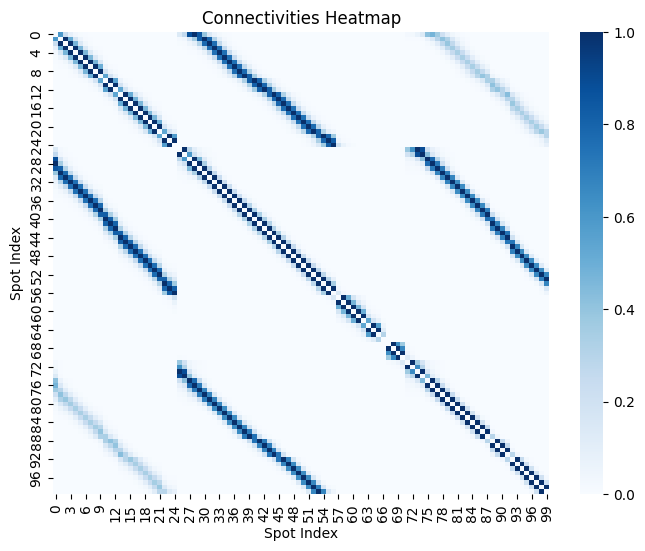

(23444, 23444) (23444, 23444)
Connectivities formed.


In [19]:
spots_per_side = 100

print("Starting Moran's I Calculation.")
moran_clusters = ad.AnnData(locations)
sc.pp.neighbors(moran_clusters, n_pcs=0, n_neighbors=100)
print("Neighbors calculated.")

connectivities_submatrix = moran_clusters.obsp["connectivities"][:spots_per_side, :spots_per_side].A
# connectivities_submatrix = same_cluster[:spots_per_side, :spots_per_side]

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(connectivities_submatrix, cmap='Blues')
plt.title('Connectivities Heatmap')
plt.xlabel('Spot Index')
plt.ylabel('Spot Index')
plt.show()

# Create a binary adjacency matrix indicating if points are in the same cluster
cluster_labels = clusters.values
same_cluster = (cluster_labels[:, None] == cluster_labels).astype(int)
print(moran_clusters.obsp["connectivities"].shape, same_cluster.shape)
moran_clusters.obsp["connectivities"] = moran_clusters.obsp["connectivities"].multiply(csr_matrix(same_cluster))
print("Connectivities formed.")

# Calculate Moran's I for the genes
morans_i = sc.metrics.morans_i(moran_clusters, vals=clustering.xenium_spot_data.X.T)

morans_i_dict = dict(zip(clustering.xenium_spot_data.var.index, morans_i))

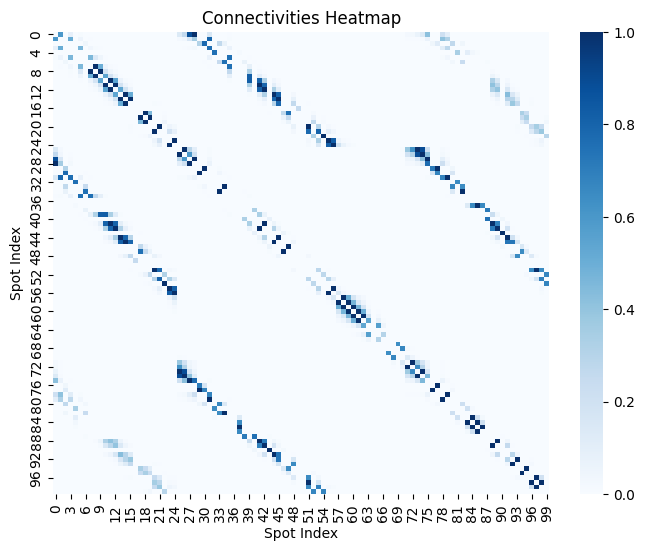

In [20]:
# Extract the first 10x10 submatrix of the connectivities matrix
connectivities_submatrix = moran_clusters.obsp["connectivities"][:spots_per_side, :spots_per_side].A
# connectivities_submatrix = same_cluster[:spots_per_side, :spots_per_side]

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(connectivities_submatrix, cmap='Blues')
plt.title('Connectivities Heatmap')
plt.xlabel('Spot Index')
plt.ylabel('Spot Index')
plt.show()

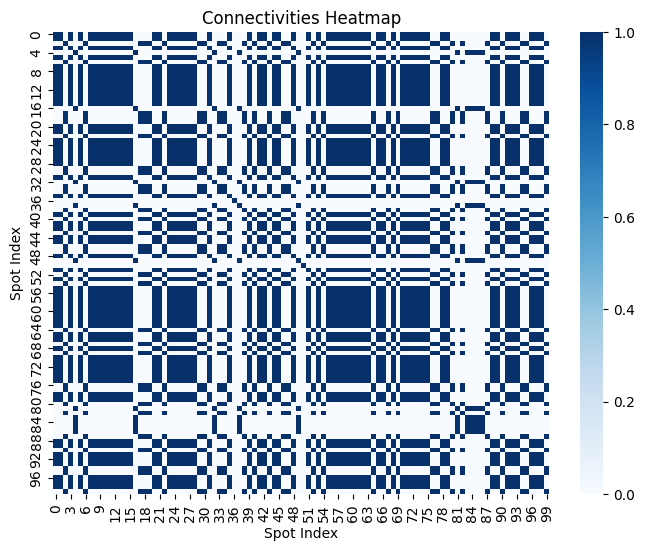

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

spots_per_side = 100

# Extract the first 10x10 submatrix of the connectivities matrix
# connectivities_submatrix = moran_clusters.obsp["connectivities"][:spots_per_side, :spots_per_side].A
connectivities_submatrix = same_cluster[:spots_per_side, :spots_per_side]

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(connectivities_submatrix, cmap='Blues')
plt.title('Connectivities Heatmap')
plt.xlabel('Spot Index')
plt.ylabel('Spot Index')
plt.show()

# Sanity Check of Clusters and Moran's I Values

/tmp/ipykernel_1146753/3024920468.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cluster_grid[rows, columns] = torch.tensor(clusters) + 1
/tmp/ipykernel_1146753/3024920468.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', num_clusters + 1)


Text(0.5, 1.0, 'Prior Cluster Assignment with BayXenSmooth')

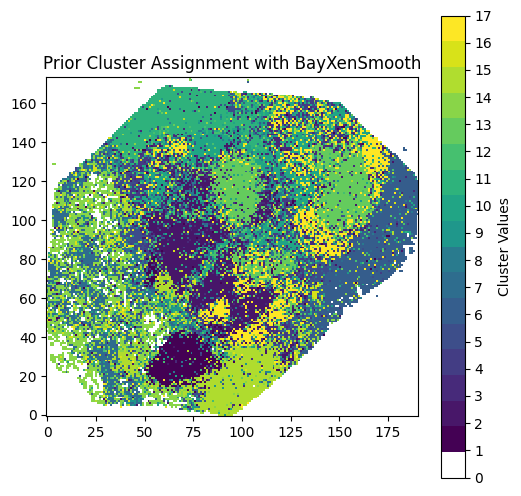

In [39]:
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

num_clusters = K

rows = locations["row"].astype(int)
columns = locations["col"].astype(int)

num_rows = max(rows) + 1
num_cols = max(columns) + 1

cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.long)

cluster_grid[rows, columns] = torch.tensor(clusters) + 1

colors = plt.cm.get_cmap('viridis', num_clusters + 1)

colormap_colors = np.vstack(([[1, 1, 1, 1]], colors(np.linspace(0, 1, num_clusters))))
colormap = ListedColormap(colormap_colors)

plt.figure(figsize=(6, 6))
plt.imshow(cluster_grid, cmap=colormap, interpolation='nearest', origin='lower')
plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
plt.title('Prior Cluster Assignment with BayXenSmooth')